In [1]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from typing import List, Tuple

In [2]:
data = pd.DataFrame({
    'sex': ['M', 'M'],
    'marital': ['S', 'M'],
    'homeowner': ['Y', 'N']
})

# Overlapping Simlarity

Given two `n`-dimensional feature vectors, `x` and `y`, overlapping similarity is given by

$$
s^{O}(x, \widetilde{x}) = 1 - d^{H}(x, \widetilde{x})
$$

where $d^{H}(x, \widetilde{x})$ is the Hamming distance defined as the number of features that $x$ and $\widetilde{x}$ do not match, divided by the total number of features:

$$
d^{H}(x, \widetilde{x}) = \frac{\sum_{i=1}^{n}\delta(x_{i}, \widetilde{x}_{i})}{n}
$$

where

$$
\begin{equation}
\delta(x_{i}, \widetilde{x}_{i}) = \begin{cases}
    1, & x_{i} \neq \widetilde{x}_{i} \\
    0, & x_{i} = \widetilde{x}_{i}
\end{cases}
\end{equation}
$$

By way of example, in the following dataset we have two feature vectors (i.e., two different observations). Both are male, but differ in marital status and homeowner status:

In [3]:
data

,sex,marital,homeowner
0,M,S,Y
1,M,M,N


In [4]:
feature_difference = list(data.loc[0,:] != data.loc[1,:])
print(f'Do the pairwise features differ? {feature_difference}')

hamming_distance = sum(feature_difference) / data.shape[1]
print(f'Hamming distance between two observations: {hamming_distance}')

overlapping_similarity = 1 - hamming_distance
print(f'Overlapping similarity: {overlapping_similarity}')

Do the pairwise features differ? [False, True, True]
Hamming distance between two observations: 0.6666666666666666
Overlapping similarity: 0.33333333333333337


# Weighted Hamming Distance

Rather than averaging across all features in the vector, we can instead use a weighted measure that averages on a per-feature basis with respect to the number of distinct values that the specific feature can take on:
$$
d^{WH}(x, \widetilde{x}) = \sum_{i=1}^{n}\frac{\delta(x_{i}, \widetilde{x}_{i})}{|\mathcal{D}_{i}|}
$$

where $|\mathcal{D}_{i}|$ is the _number_ of distinct possible values that a particular feature is able to assume. (E.g., for homeowner, there would be a cardinality of $2$ since you either are or are not a homeowner.) Applying this weighted distance to the above dataset yields:

In [5]:
cardinality = data.nunique()
print(f'Number of distinct possible values for each feature: {cardinality}')

feature_difference = np.array(data.loc[0,:] != data.loc[1,:])
print(f'Do the pairwise features differ? {feature_difference}')

w_hamming_distance = sum(feature_difference / cardinality)
print(f'Weighted Hamming distance between two observations: {w_hamming_distance}')

Number of distinct possible values for each feature: sex          1
marital      2
homeowner    2
dtype: int64
Do the pairwise features differ? [False  True  True]
Weighted Hamming distance between two observations: 1.0


Note that in the above, we can no longer use the overlapping similarity metric defined previously since our weighted Hamming distance is no longer bounded on a $[0, 1]$ interval.

# Extension to a Kernel

A kernel function, or a kernel trick, at a high level is a mapping of data into a higher-dimensional, implicit feature space such that we can identify a hyperplane in which our data are linearly separable. Intuitively, the mapping can be visualized as:

![](./assets/kernel.png)

> Kernel methods apply standard machine learning algorithms that rely on distance metrics or inner products to data embedded into a feature space using kernel functions. The embedding of the data into a feature space is expected to capture and enhance the patterns and regularities in the data. Kernel methods proceed in two steps. The first step embeds the data into a feature space of high or infinite dimension, while the second step uses standard algorithms for classification, clustering, and principal component analysis to detect the regularities of the data in the feature space. The core of kernel methods relies on the use of kernel functions. A kernel function computes the inner product in a feature space of the embedding of two data points under a certain mapping, $\phi$

We can extend our Hamming distance to apply to a Gaussian kernel, by replacing Euclidean distance with it:
$$
k^{GH}(x, \widetilde{x}) = e^{-\frac{\delta(x, \widetilde{x})}{2\sigma^{2}}}
$$
where $\sigma > 0$ is a constant kernel width parameter.

## Adaptive Gaussian Kernel

In the above, $\sigma$ is a constant parameter. We can, however, use an adaptive bandwidth parameter:
$$
k^{GH}(x, \widetilde{x}) = e^{-\frac{\delta(x, \widetilde{x})}{\beta(x,\widetilde{x})}}
$$
where $\beta(x, \widetilde{x})$ is an adaptive bandwidth determined by a fixed number of nearest neighbors of data instance $x$ and $\widetilde{x}$.

## Hamming Distance Kernel

We can extend the above to a Hamming Distance Kernel, in which we consider $\mathcal{D}^{n}$ to be the cross product over all $n$ input features. Formally, we can define this by

_Let $D_{i}$ by a finite domain of categorical values. Let $(a_{1}, \ldots, a_{n})$ by a categorical object such that $a_{i}\in D_{i}$. Let $D^{n}=\prod_{i=1}^{n}D_{i}$ be the cross product over all the domains of the attributes such that for each $(u_{1}, \ldots, u_{n})\in D^{n}$, $u_{i}\in D_{i}$. Given a categorical object $s = (s_{1}, \ldots, s_{n})$, $s_{k}$ denotes the value of the $k$-th attribute of $s$_

To start, we begin be again ensuring that our columns are defined as categorical and then dummy encoding them to integers. I will also initialize an all-ones `NxN` kernel matrix where `N` is equal to the length of my dataset.

In [6]:
data = pd.DataFrame({
    'sex': ['M', 'M', 'F'],
    'marital': ['S', 'M', 'S'],
    'homeowner': ['Y', 'N', 'Y']
}, dtype='category')
data = data.apply(lambda x: x.cat.codes)

cardinality = data.nunique()
damping_param = 0.6
n = data.shape[0]
k_j = np.ones(shape=(n, n))

For each observation in the dataset, we can now compute its hamming distance from every other observation in the dataset and compute the recursive kernel step as
$$
\begin{align}
k^{0}(x, \widetilde{x}) &= 1 \\
k^{j}(x, \widetilde{x}) &= (\lambda^{2}(|\mathcal{D}_{j}| - 1 - \delta(x_{j},\widetilde{x}_{j}))+(2\lambda - 1)\delta(x_{j}, \widetilde{x}_{j} + 1)k^{j-1}(x, \widetilde{x})
\end{align}
$$
for all values of $j = 1, \ldots, n$

In [7]:
for col in range(len(cardinality)):
    dhamming_j = np.not_equal.outer(
        data.iloc[:, col].values,
        data.iloc[:, col].values
    )
    k_j = (
        (damping_param**2) * (cardinality[col] - 1 - dhamming_j) +
        (2 * damping_param - 1) * dhamming_j + 1) * k_j
    
k_j

array([[2.515456, 1.9584  , 2.21952 ],
       [1.9584  , 2.515456, 1.728   ],
       [2.21952 , 1.728   , 2.515456]])

# Spectral Ranking

Now that we have a kernel matrix, we need to construct both an adjacency matrix, $W$, and a degree matrix, $D$. The adjacency matrix allows us to represent the data using an undirected graph $G=(V,E)$, with vertices $V=\{v_{1}, v_{2}, \ldots, v_{n}\}$ corresponding to data instances (i.e., the rows and columns), and the cell values corresponding to the edges connecting each vertex to another. This allows us to summarize the similarity between two corresponding data instances, where $W_{ij}$ is the similarity between $v_{i}$ and $v_{j}$.

To construct this adjacency matrix, we will normalize our kernel matrix such that the diagonal (a comparison of any observation against itself) is equal to $1$.

In [8]:
kern_diag = 1 / np.sqrt(np.diag(k_j))
W = k_j * np.outer(kern_diag, kern_diag)
print(W)

[[1.         0.77854671 0.88235294]
 [0.77854671 1.         0.68695298]
 [0.88235294 0.68695298 1.        ]]


We can then construct a degree vector $d$ of each vertex with $x_{i} = \sum_{j}W_{ij}$ (i.e., the row sum for the observation), and from that create a degree matrix, $D$, with $d$ on the diagonal.

In [9]:
n = W.shape[0]
ident = np.zeros((n, n), float)
np.fill_diagonal(ident, 1.)

# Let D be the degree matrix of each vertex corresponding
# the the row sum of the similarity matrix W
d = np.sum(k_j, axis=1)
D = np.zeros((n, n), float)
np.fill_diagonal(D, d)
D

array([[6.693376, 0.      , 0.      ],
       [0.      , 6.201856, 0.      ],
       [0.      , 0.      , 6.462976]])

Having done this, we will now create a symmetric normalized Laplacian, $L=I - D^{-1/2}WD^{-1/2}$ where $I$ is an identity matrix.

In [10]:
D_inv_sqrt = np.linalg.inv(np.sqrt(D))

# Let L be the symmetric normalized Laplacian
L = ident - np.dot(D_inv_sqrt, W).dot(D_inv_sqrt)
L

array([[ 0.85059856, -0.12083736, -0.13415395],
       [-0.12083736,  0.83875795, -0.10850504],
       [-0.13415395, -0.10850504,  0.84527252]])

We can now extract the first and second non-principal eigenvectors for visualization

In [11]:
# Extract the 2 non-principal eigenvectors.
#
# The eig() function returns 2 arrays: the
# first represents eigenvalues, the second
# eigenvectors. The eigenvectors are not
# arranged in order of magnitude. We sort
# and then sample the second and third vectors
eig_vals, eig_vecs = np.linalg.eig(L)
eig_vecs = eig_vecs[:, eig_vals.argsort()[::][1:]]
eig_vecs

array([[ 0.2149818 , -0.77975547],
       [-0.79803158,  0.20681425],
       [ 0.56296396,  0.59093932]])

The authors also define a bi-class clustering strength measure $z^{*} = D^{1/2}g_{1}^{*}$ where $g^{*}$ is the first non-principal eigenvector for the normalized spectral optimization.

In [12]:
# Components of the first non-principal
# eigenvectors in the feature space.
#
# Note that here we're just duplicating
# D_sqrt column-wise so that its dimensionality
# is equal to that of npeigen
z = np.sqrt(d) * eig_vecs[:, 0]
z

array([ 0.55619144, -1.98738002,  1.43118858])

Finally, we can delineate between the normal case and cases where only one major pattern exists:

In [13]:
# Let C_p be the positive class and and C_n
# the negative class assigned based on the
# sign of the 1st non-principal eigenvector
# component of z
C = np.sign(z)
C_cnt = np.unique(C, return_counts=True)
C_cnt = pd.DataFrame(
    data=np.array(C_cnt[1])[np.newaxis],
    columns=C_cnt[0])

if C_cnt.iloc[[0]].min(axis=1)[0]/n >= 0.4:
    mFLAG = 1
    f = np.max(np.abs(z)) - np.abs(z)
else:
    if C_cnt[1][0] > C_cnt[-1][0]:
        mFLAG = 0
        f = -z
    else:
        mFLAG = 0
        f = z
f

array([-0.55619144,  1.98738002, -1.43118858])

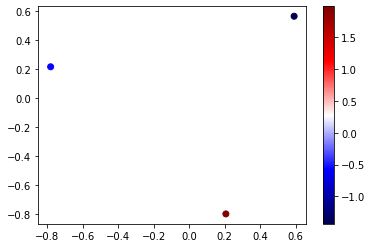

In [14]:
p = plt.scatter(
    x=eig_vecs[:, 1],
    y=eig_vecs[:, 0],
    c=f,
    cmap='seismic'
)
p = plt.colorbar()